# Undirected GraphSAGE on the CORA citation network using StellarGraph and Neo4j

<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/connector/neo4j/undirected-graphsage-on-cora-neo4j-example.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/connector/neo4j/undirected-graphsage-on-cora-neo4j-example.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]

In [2]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.connector.neo4j import Neo4JGraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

import numpy as np
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import time
%matplotlib inline

### Loading the CORA data from Neo4J

It is assumed that the cora dataset has already been loaded into Neo4J. [This notebook](./load-cora-into-neo4j.ipynb) demonstrates how to load cora dataset into Neo4J.

It is still required to load the node features into memory. We use ```py2neo```, which provides tools to connect to Neo4J databases from Python applications. ```py2neo``` documentation could be found [here](https://py2neo.org/v4/).

In [3]:
import py2neo

default_host = os.environ.get("STELLARGRAPH_NEO4J_HOST")

# Create the Neo4J Graph database object; the arguments can be edited to specify location and authentication
neo4j_graphdb = py2neo.Graph(host=default_host, port=None, user=None, password=None)

In [4]:
def get_node_data_from_neo4j(neo4j_graphdb):
    fetch_node_query = "MATCH (node) RETURN id(node), properties(node)"
    # run the query
    node_records = neo4j_graphdb.run(fetch_node_query)
    # convert the node records into pandas dataframe
    return pd.DataFrame(node_records).rename(columns={0: "id", 1: "attr"})


start = time.time()
node_data = get_node_data_from_neo4j(neo4j_graphdb)
end = time.time()

print(f"{end - start:.2f} s: Loaded node data from neo4j database to memory")

3.07 s: Loaded node data from neo4j database to memory


Extract the node_features:

In [5]:
node_data = node_data.set_index("id")
attribute_df = node_data["attr"].apply(pd.Series)
node_data = attribute_df.drop(labels=["ID"], axis=1)
node_features = pd.DataFrame(node_data["features"].values.tolist(), index=node_data.index)
node_data.head(5)

,features,subject
id,,
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Neural_Networks
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",Rule_Learning
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Reinforcement_Learning
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Reinforcement_Learning
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Probabilistic_Methods


We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [6]:
labels = np.array(node_data["subject"])
set(labels)

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn again to do this.

In [7]:
train_data, test_data = model_selection.train_test_split(
    node_data, train_size=0.1, test_size=None, stratify=node_data["subject"]
)

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training.

In [8]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict("records"))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict("records"))

## Creating the GraphSAGE model in Keras

Now create a *undirected* StellarGraph object storing node data. Since the subgraph is sampled directly from Neo4J, we only need to retain the node features and do not need to store any edges.

In [9]:
G = sg.StellarGraph(nodes={"paper": node_features}, edges={})

In [10]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 0

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: none

 Edge types:


To feed data from the graph to the Keras model we need a data generator that feeds data from the graph to the model. The generators are specialized to the model and the learning task so we choose the `Neo4JGraphSAGENodeGenerator` as we are predicting node attributes with a GraphSAGE model, sampling directly from Neo4J database.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer, and 5 in the second.

In [11]:
batch_size = 50
num_samples = [10, 5]

A `Neo4JGraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras.

In [12]:
generator = Neo4JGraphSAGENodeGenerator(G, batch_size, num_samples, neo4j_graphdb)

Using the `generator.flow()` method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training.

In [13]:
train_gen = generator.flow(train_data.index, train_targets, shuffle=True)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer.
 * The `bias` and `dropout` are internal parameters of the model. 

In [14]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

Now we create a model to predict the 7 categories using Keras softmax layers.

In [15]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [16]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [17]:
test_gen = generator.flow(test_data.index, test_targets)

In [18]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

  ['...']
  ['...']
Train for 6 steps, validate for 49 steps
Epoch 1/20
6/6 - 5s - loss: 1.8584 - acc: 0.2741 - val_loss: 1.7075 - val_acc: 0.3113
Epoch 2/20
6/6 - 4s - loss: 1.6480 - acc: 0.3444 - val_loss: 1.5590 - val_acc: 0.4454
Epoch 3/20
6/6 - 4s - loss: 1.4776 - acc: 0.6148 - val_loss: 1.3975 - val_acc: 0.6862
Epoch 4/20
6/6 - 4s - loss: 1.3258 - acc: 0.7778 - val_loss: 1.2655 - val_acc: 0.7441
Epoch 5/20
6/6 - 4s - loss: 1.1810 - acc: 0.8556 - val_loss: 1.1604 - val_acc: 0.7724
Epoch 6/20
6/6 - 4s - loss: 1.0659 - acc: 0.8778 - val_loss: 1.0739 - val_acc: 0.7929
Epoch 7/20
6/6 - 4s - loss: 0.9628 - acc: 0.9037 - val_loss: 0.9981 - val_acc: 0.8048
Epoch 8/20
6/6 - 4s - loss: 0.8450 - acc: 0.9444 - val_loss: 0.9395 - val_acc: 0.8130
Epoch 9/20
6/6 - 4s - loss: 0.7773 - acc: 0.9259 - val_loss: 0.8995 - val_acc: 0.8171
Epoch 10/20
6/6 - 4s - loss: 0.6998 - acc: 0.9556 - val_loss: 0.8573 - val_acc: 0.8072
Epoch 11/20
6/6 - 4s - loss: 0.6176 - acc: 0.9593 - val_loss: 0.8223 - val_acc

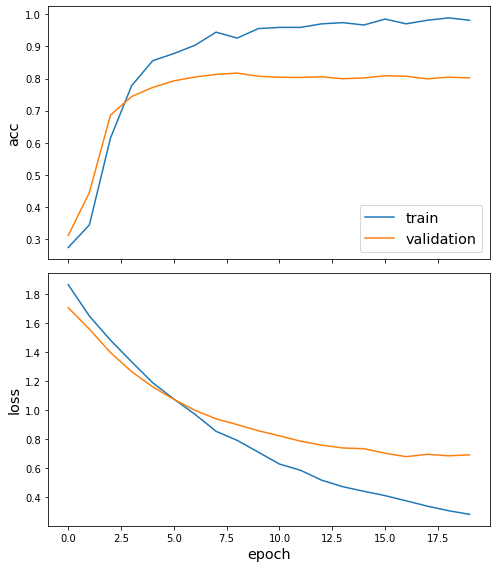

In [19]:
sg.utils.plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [20]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ['...']

Test Set Metrics:
	loss: 0.6876
	acc: 0.8052


### Making predictions with the model

Now let's get the predictions themselves for all nodes using another node iterator:

In [21]:
all_nodes = node_data.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

In [22]:
node_predictions = target_encoding.inverse_transform(all_predictions)

Let's have a look at a few:

In [23]:
results = pd.DataFrame(node_predictions, index=all_nodes).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data["subject"]})
df.head(10)

,Predicted,True
id,,
0,subject=Theory,Neural_Networks
1,subject=Rule_Learning,Rule_Learning
2,subject=Reinforcement_Learning,Reinforcement_Learning
3,subject=Reinforcement_Learning,Reinforcement_Learning
4,subject=Probabilistic_Methods,Probabilistic_Methods
5,subject=Probabilistic_Methods,Probabilistic_Methods
6,subject=Reinforcement_Learning,Theory
7,subject=Neural_Networks,Neural_Networks
8,subject=Theory,Neural_Networks


Please refer to [directed-graphsage-on-cora-example.ipynb](./../../node-classification/graphsage/graphsage-cora-node-classification-example.ipynb) for **node embedding visualization**.

<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/connector/neo4j/undirected-graphsage-on-cora-neo4j-example.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/connector/neo4j/undirected-graphsage-on-cora-neo4j-example.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>